In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score,cross_val_predict ,GridSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import r_regression
from os import listdir
from os.path import isfile, join

pd.set_option('display.max_columns', None)

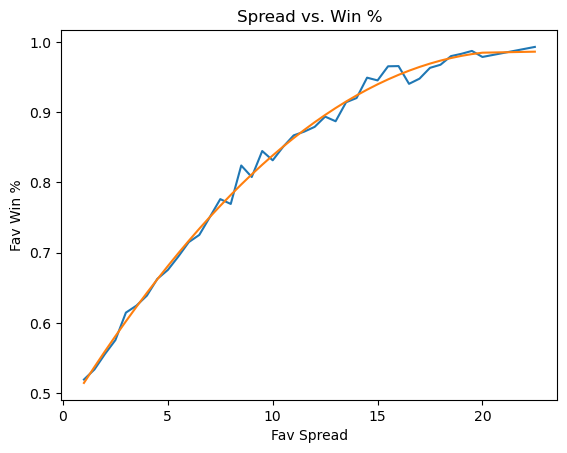

[-0.00112458  0.04837471  0.46721351]


In [2]:
# Spread to Win % Data taken from boydsbets.com, based on historical spread data
# This data is used to convert the models point spread predictions into the submission format
# Will be accomplished by linear regression using polyfit to extract predictions

# Want to fit y = Aln(x) + B

x = np.array([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5,
              16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 22.5])
# , 20.5, 21, 21.5, 22,    , 23, 23.5, 24, 24.5
y = np.array([0.5193, 0.5336, 0.5556, 0.5755, 0.6146, 0.6245, 0.6388, 0.6627, 0.6754, 0.6945, 0.7151, 0.7253, 0.7506, 0.7763, 0.7694, 0.8242, 
              0.8078, 0.8448, 0.8316, 0.8509, 0.8671, 0.8724, 0.8792, 0.8938, 0.8872, 0.9143, 0.9203, 0.9493, 0.9454, 0.9655, 0.9658, 0.9405,
              0.9479, 0.9633, 0.9677, 0.9800, 0.9833, 0.9874, 0.9788, 0.9931])
# 0.9751, 0.9727, 0.9706, 0.9786,   , 0.9919, 0.9910, 0.9912, 0.9818
plt.plot(x, y)
plt.xlabel("Fav Spread")
plt.ylabel("Fav Win %")
plt.title("Spread vs. Win %")
# plt.show()

coeffs = np.polyfit(x, y, 2)
a = coeffs[0]
b = coeffs[1]
c = coeffs[2]

y_fitted = a*x**2 + b*x +c
plt.plot(x, y_fitted)
plt.show()

print(coeffs)

In [132]:
dirname = './data/'


df_MSeason = pd.read_csv(dirname + 'MRegularSeasonDetailedResults.csv')
df_WSeason = pd.read_csv(dirname + 'WRegularSeasonDetailedResults.csv')

SampleSubmission = pd.read_csv(dirname + 'SampleSubmissionStage1.csv')

In [133]:
# Create dataframe of average team stats for the given year

df_MSeason_singleYear = df_MSeason[df_MSeason['Season']==2025]

winners = df_MSeason_singleYear[['WTeamID', 'WScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'Score', 'WFGM': 'FGM', 'WFGA': 'FGA', 'WFGM3': 'FGM3', 'WFGA3': 'FGA3', 'WFTM': 'FTM', 'WFTA': 'FTA', 'WOR': 'OR', 'WDR': 'DR', 'WAst': 'Ast', 'WTO': 'TO', 'WStl': 'Stl', 'WBlk': 'Blk', 'WPF': 'PF'}
)

losers = df_MSeason_singleYear[['LTeamID', 'LScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']].rename(
    columns={'LTeamID': 'TeamID', 'LScore': 'Score', 'LFGM': 'FGM', 'LFGA': 'FGA', 'LFGM3': 'FGM3', 'LFGA3': 'FGA3', 'LFTM': 'FTM', 'LFTA': 'FTA', 'LOR': 'OR', 'LDR': 'DR', 'LAst': 'Ast', 'LTO': 'TO', 'LStl': 'Stl', 'LBlk': 'Blk', 'LPF': 'PF'}
)

combined_teams = pd.concat([winners, losers])
team_stats = combined_teams.groupby('TeamID').mean().reset_index()

win_percent = pd.DataFrame(columns=['TeamID', 'Win%'])
win_percent['TeamID'] = team_stats['TeamID']
for index, team in enumerate(team_stats['TeamID']):
    win_percent.loc[index, 'Win%'] = len(df_MSeason_singleYear[df_MSeason_singleYear['WTeamID']==team])/(len(df_MSeason_singleYear[df_MSeason_singleYear['WTeamID']==team]) + len(df_MSeason_singleYear[df_MSeason_singleYear['LTeamID']==team]))

team_stats['Win%'] = win_percent['Win%']
team_stats.head()

TeamID      Score        FGM        FGA       FGM3       FGA3        FTM  \
0    1101  65.111111  23.111111  54.777778   4.055556  14.500000  14.833333   
1    1102  63.333333  21.666667  49.666667   8.047619  23.666667  11.952381   
2    1103  82.833333  29.666667  65.722222  11.222222  30.777778  12.277778   
3    1104  90.350000  30.400000  64.250000   9.900000  30.500000  19.650000   
4    1105  71.352941  23.941176  62.705882   7.764706  25.705882  15.705882   

         FTA         OR         DR        Ast        TO       Stl        Blk  \
0  21.166667   8.611111  18.944444  12.166667  9.444444  2.833333  14.277778   
1  19.047619   6.000000  20.523810  13.333333  5.857143  3.047619  11.761905   
2  16.333333  10.388889  25.666667  17.666667  7.666667  3.666667  12.666667   
3  27.700000  11.900000  28.650000  17.000000  6.500000  5.000000  12.100000   
4  23.411765  12.529412  20.764706  13.000000  8.470588  3.941176  16.294118   

          PF      Win%  
0  21.055556  0.333333  
1  17.285714  0.142857  
2  19.055556  0.722222  
3  18.600000      0.85  
4  21.588235  0.235294

In [134]:
import itertools
# Create dataframe for every possible matchup for given year

teams = team_stats['TeamID'].tolist()
team_combinations = list(itertools.combinations(teams, 2))

# Convert to DataFrame
submission_test_data = pd.DataFrame(team_combinations, columns=['1TeamID', '2TeamID'])

# Merge statistics for Team_1
submission_test_data = submission_test_data.merge(team_stats, left_on='1TeamID', right_on='TeamID', suffixes=('_1', ''))
submission_test_data.drop(columns=['TeamID'], inplace=True)

# Merge statistics for Team_2
submission_test_data = submission_test_data.merge(team_stats, left_on='2TeamID', right_on='TeamID', suffixes=('_1', '_2'))
submission_test_data.drop(columns=['TeamID'], inplace=True)
submission_test_data.columns = ['1TeamID', '2TeamID', '1Score', '1FGM', '1FGA', '1FGM3', '1FGA3', '1FTM', '1FTA', '1OR', '1DR', '1Ast', '1TO', '1Stl', '1Blk', '1PF', '1Win%',
                         '2Score', '2FGM', '2FGA', '2FGM3', '2FGA3', '2FTM', '2FTA', '2OR', '2DR', '2Ast', '2TO', '2Stl', '2Blk', '2PF', '2Win%']

In [135]:
# Add Win%
df_MSeason['1Win%'] = 0.
df_MSeason['2Win%'] = 0.

df_MSeason['1Win%'] = df_MSeason['WTeamID'].map(team_stats.set_index('TeamID')['Win%'])
df_MSeason['2Win%'] = df_MSeason['LTeamID'].map(team_stats.set_index('TeamID')['Win%'])

# Transpose W L to team 1 2. Randomly flip 50% of teams 1 and 2 so that 1m2diff can take on negative values
df_MSeason = df_MSeason.drop(columns=['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WLoc', 'NumOT'])
df_MSeason.columns = ['1Score', '2Score', '1FGM', '1FGA', '1FGM3', '1FGA3', '1FTM', '1FTA', '1OR', '1DR', '1Ast', '1TO', '1Stl', '1Blk', '1PF',
                      '2FGM', '2FGA', '2FGM3', '2FGA3', '2FTM', '2FTA', '2OR', '2DR', '2Ast', '2TO', '2Stl', '2Blk', '2PF', '1Win%', '2Win%']

mask = np.random.rand(len(df_MSeason)) < 0.5

df_MSeason.loc[mask, ['1Score', '2Score']] = df_MSeason.loc[mask, ['2Score', '1Score']].values

for i in np.arange(13):
    df_MSeason.loc[mask, [df_MSeason.columns[i+2], df_MSeason.columns[i+15]]] = df_MSeason.loc[mask, [df_MSeason.columns[i+15], df_MSeason.columns[i+2]]].values

In [136]:
#Add features to df_MSeason and submission_test_data

#Add FG%, 2P%, and 3P%, and TotR
df_MSeason['1FG%'] = df_MSeason['1FGM']/df_MSeason['1FGA']
df_MSeason['12P%'] = (df_MSeason['1FGM']-df_MSeason['1FGM3'])/(df_MSeason['1FGA']-df_MSeason['1FGA3'])
df_MSeason['13P%'] = df_MSeason['1FGM3']/df_MSeason['1FGA3']
df_MSeason['1TotR'] = df_MSeason['1OR'] + df_MSeason['1DR']
df_MSeason['2FG%'] = df_MSeason['2FGM']/df_MSeason['2FGA']
df_MSeason['22P%'] = (df_MSeason['2FGM']-df_MSeason['2FGM3'])/(df_MSeason['2FGA']-df_MSeason['2FGA3'])
df_MSeason['23P%'] = df_MSeason['2FGM3']/df_MSeason['2FGA3']
df_MSeason['2TotR'] = df_MSeason['2OR'] + df_MSeason['2DR']

submission_test_data['1FG%'] = submission_test_data['1FGM']/submission_test_data['1FGA']
submission_test_data['12P%'] = (submission_test_data['1FGM']-submission_test_data['1FGM3'])/(submission_test_data['1FGA']-submission_test_data['1FGA3'])
submission_test_data['13P%'] = submission_test_data['1FGM3']/submission_test_data['1FGA3']
submission_test_data['1TotR'] = submission_test_data['1OR'] + submission_test_data['1DR']
submission_test_data['2FG%'] = submission_test_data['2FGM']/submission_test_data['2FGA']
submission_test_data['22P%'] = (submission_test_data['2FGM']-submission_test_data['2FGM3'])/(submission_test_data['2FGA']-submission_test_data['2FGA3'])
submission_test_data['23P%'] = submission_test_data['2FGM3']/submission_test_data['2FGA3']
submission_test_data['2TotR'] = submission_test_data['2OR'] + submission_test_data['2DR']

#Add D Parameter
df_MSeason['1DParameter'] = np.exp(-df_MSeason['1TO']/df_MSeason['1TotR'])
df_MSeason['2DParameter'] = np.exp(-df_MSeason['2TO']/df_MSeason['2TotR'])

submission_test_data['1DParameter'] = np.exp(-submission_test_data['1TO']/submission_test_data['1TotR'])
submission_test_data['2DParameter'] = np.exp(-submission_test_data['2TO']/submission_test_data['2TotR'])

#Add Adj Stats for SOS

In [137]:
sos.head()

TeamID  Base_SOS
0    1101  0.475414
1    1102  0.537698
2    1103    0.4947
3    1104  0.669428
4    1105  0.373987

In [138]:
# Calculate SOS

df_MSeason_singleYear['1Win%'] = 0.
df_MSeason_singleYear['2Win%'] = 0.

df_MSeason_singleYear['1Win%'] = df_MSeason_singleYear['WTeamID'].map(team_stats.set_index('TeamID')['Win%'])
df_MSeason_singleYear['2Win%'] = df_MSeason_singleYear['LTeamID'].map(team_stats.set_index('TeamID')['Win%'])

team_sos = pd.concat([
    df_MSeason_singleYear[['WTeamID', '2Win%']].rename(columns={'WTeamID': 'TeamID', '2Win%': 'Opp_Win%'}),
    df_MSeason_singleYear[['LTeamID', '1Win%']].rename(columns={'LTeamID': 'TeamID', '1Win%': 'Opp_Win%'}),
])

sos = team_sos.groupby('TeamID')['Opp_Win%'].mean().reset_index()
sos.rename(columns={'Opp_Win%': 'Base_SOS'}, inplace=True)

team_stats = team_stats.merge(sos, on='TeamID', how='left')

# Compute Opponent's Opponent Strength
df_MSeason_singleYear = df_MSeason_singleYear.merge(sos, left_on='WTeamID', right_on='TeamID', how='left').drop(columns=['TeamID'])
df_MSeason_singleYear = df_MSeason_singleYear.merge(sos, left_on='LTeamID', right_on='TeamID', how='left', suffixes=('', '_oppSOS')).drop(columns=['TeamID'])

# Compute Opponent’s Opponent SOS
opp_sos = pd.concat([
    df_MSeason_singleYear[['WTeamID', 'Base_SOS_oppSOS']].rename(columns={'WTeamID': 'TeamID', 'Base_SOS_oppSOS': 'Opp_Opp_SOS'}),
    df_MSeason_singleYear[['LTeamID', 'Base_SOS']].rename(columns={'LTeamID': 'TeamID', 'Base_SOS': 'Opp_Opp_SOS'})
])

opp_sos = opp_sos.groupby('TeamID')['Opp_Opp_SOS'].mean().reset_index()

team_stats = team_stats.merge(opp_sos, on='TeamID', how='left')

team_stats['Adj_SOS'] = 0.67 * team_stats['Base_SOS'] + 0.33 * team_stats['Opp_Opp_SOS']

team_stats.drop(columns=['Base_SOS', 'Opp_Opp_SOS'], inplace=True)
team_stats.head()

TeamID      Score        FGM        FGA       FGM3       FGA3        FTM  \
0    1101  65.111111  23.111111  54.777778   4.055556  14.500000  14.833333   
1    1102  63.333333  21.666667  49.666667   8.047619  23.666667  11.952381   
2    1103  82.833333  29.666667  65.722222  11.222222  30.777778  12.277778   
3    1104  90.350000  30.400000  64.250000   9.900000  30.500000  19.650000   
4    1105  71.352941  23.941176  62.705882   7.764706  25.705882  15.705882   

         FTA         OR         DR        Ast        TO       Stl        Blk  \
0  21.166667   8.611111  18.944444  12.166667  9.444444  2.833333  14.277778   
1  19.047619   6.000000  20.523810  13.333333  5.857143  3.047619  11.761905   
2  16.333333  10.388889  25.666667  17.666667  7.666667  3.666667  12.666667   
3  27.700000  11.900000  28.650000  17.000000  6.500000  5.000000  12.100000   
4  23.411765  12.529412  20.764706  13.000000  8.470588  3.941176  16.294118   

          PF      Win%   Adj_SOS  
0  21.055556  0.333333  0.482912  
1  17.285714  0.142857  0.525075  
2  19.055556  0.722222  0.491219  
3  18.600000      0.85   0.63269  
4  21.588235  0.235294   0.40457

In [140]:
# Add point differential of Team 1 - Team 2

df_MSeason["1m2Diff"] = df_MSeason["1Score"] - df_MSeason["2Score"]
df_MSeason = df_MSeason.drop(columns=['1Score', '2Score'])

In [95]:
#Train Test Split
X = df_MSeason.iloc[:, :-1]
y = df_MSeason.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [96]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Train random forest and get feature importances
model = RandomForestRegressor()

#Fit Feature Selection Model
model.fit(X_train_scaled, y_train.values.ravel())
importances = model.feature_importances_

feature_importances = pd.Series(importances, index=X_train.columns)
print(feature_importances.sort_values(ascending=False))

2FG%           0.260076
1FG%           0.251723
2FGM           0.102627
1FGM           0.095258
1DParameter    0.049045
2DParameter    0.048855
2FTM           0.044332
1FTM           0.044324
1FGM3          0.013720
2FGM3          0.013019
13P%           0.007098
23P%           0.006807
2Ast           0.003988
2FGA3          0.003945
1FGA3          0.003855
1Ast           0.003772
1FTA           0.003763
2FTA           0.003759
1Win%          0.003051
1TotR          0.003007
2Win%          0.002776
2TotR          0.002645
1PF            0.002138
2PF            0.002133
22P%           0.002070
12P%           0.002004
2FGA           0.001892
1FGA           0.001805
2DR            0.001795
1DR            0.001747
2Blk           0.001724
2OR            0.001706
1OR            0.001699
1Blk           0.001689
2TO            0.001689
1TO            0.001555
1Stl           0.001458
2Stl           0.001449
dtype: float64


In [ ]:
feature_importances.sort_values(ascending=False, inplace=True)
selected_features = feature_importances.index[:8]
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train_selected, y_train.values.ravel())

In [ ]:
# #Save Model

# import pickle

# with open('svm_model1.pkl', 'wb') as file:
#     pickle.dump(model, file)

In [ ]:
predictions = model.predict(X_test_selected)

In [ ]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

rmse = root_mean_squared_error(y_test, predictions)

plt.scatter(predictions, y_test)
plt.xlabel("Predicted Winner Point Diff")
plt.ylabel("Actual Winner Point Diff")

x = np.array([-65, 65])
y = x
plt.plot(x, y, color='red')
plt.figure(figsize=(12,12))

plt.show()
print("RMSE = " + str(rmse))

In [ ]:
submission_test_data_scaled = submission_test_data.drop(columns=['1TeamID', '2TeamID', '1Score', '2Score'])

submission_test_data_scaled = scaler.transform(submission_test_data_scaled)
submission_test_data_scaled = pd.DataFrame(submission_test_data_scaled, columns=submission_test_data.drop(columns=['1TeamID', '2TeamID', '1Score', '2Score']).columns)

submission_test_data_scaled = pd.concat([submission_test_data[['1TeamID', '2TeamID', '1Score', '2Score']], submission_test_data_scaled], axis=1)

In [ ]:
submission_test_data_selected = submission_test_data_scaled[selected_features]


In [ ]:
submission_pred = model.predict(submission_test_data_selected)


In [ ]:
#Calculate submission probabilities
submission_probs = []
for i, val in enumerate(submission_pred):
    if (val >= 20):
        submission_probs.append(1)
        continue
    elif (val <= -20):
        submission_probs.append(0)
        continue
    elif (val > 0):
        submission_probs.append(a*val**2 + b*val + c)
        continue
    elif (val < 0):
        submission_probs.append(1 - (a*abs(val)**2 + b*abs(val) + c))
    elif (val == 0):
        submission_probs.append(0.5)

In [ ]:
with open("output.csv", "w") as file:
    for team1, team2, prob in zip(submission_test_data['1TeamID'], submission_test_data['2TeamID'], submission_probs):
        if(team1 - team2 > 0):
            file.write(f"2025_{team1}_{team2}, {1-prob}\n") 
        else:
            file.write(f"2025_{team1}_{team2}, {prob}\n")

In [ ]:
df_Rankings=pd.DataFrame()
df_Rankings['TeamID'] = team_stats['TeamID']
df_Rankings['Score'] = 0.0

for team1, team2, prob in zip(submission_test_data['1TeamID'], submission_test_data['2TeamID'], submission_probs):
    df_Rankings.loc[df_Rankings['TeamID']==team1, 'Score'] += prob
    df_Rankings.loc[df_Rankings['TeamID']==team2, 'Score'] += (1-prob)

df_Rankings['Score'] = df_Rankings['Score'] / 363

In [ ]:
df_Teams = pd.read_csv(dirname + 'MTeams.csv')
df_Rankings = pd.merge(df_Rankings, df_Teams[['TeamID', 'TeamName']], on='TeamID', how='left')
df_Rankings.drop(columns=['TeamID'], inplace=True)
df_Rankings.sort_values(by='Score', ascending=False).reset_index(drop=True).to_csv("./MRankings.csv")

In [38]:
# Strategy
#
# Step 1
#
# Create Average Stats for each team from M/WRegularSeasonDetailedResultsCSV
# Store stats for each team in a dataframe ordered by teamID
#
# Step 2
#
# Feature Selection on complete dataset
#
# Step 3
#
# Build model from dataset to predict winners of games
# Predict and create Submission File

# Test